<a href="https://colab.research.google.com/github/fernandosjp/puc-rio-data_science/blob/main/model/model_training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criação de modelo para classificação de categoria de transações

## Introdução
Objetivo do modelo: classificar transações em categorias.

Dataset: financial transactions categorized for personal finance purposes

Notebook structure:

1. Load and pre process data
2. Select features and split into train and test datasets
3. Training phase: Create pipelines, vecotrize text data, train model, tune hyper params and evaluate models
4. Final evaluation: test against test data set (never seen data)
5. Export model, label encoder and vectorizer
6. Test against small sample
7. Result Analysis



# Import

In [1]:
# do not show warnings
import warnings
warnings.filterwarnings("ignore")

# prompt: frame to train and solected machine learning model to classify transactions into categories

import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Load and pre process data
Here we will open the csv file and transform categories in labels.

In [2]:
# Dataset URL
url = "https://raw.githubusercontent.com/fernandosjp/puc-rio-data_science/main/model/data/main.csv"
data = pd.read_csv(url, delimiter=',', encoding='utf-8')

data['Description'] = data['Description'].values.astype('U')

# Label categories
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['Category'])

# Mostra as primeiras linhas do dataset
data.head()

,Description,Category,Sub_Category,label
0,GAP Boys Grey & Black Printed Logo Chest-Strip...,Clothes,Clothes,2
1,HP VH240a 23.8-Inch Full HD 1080p IPS LED Moni...,Electronics,Computer,3
2,"Fire 7 tablet, 7"" display, 16 GB, latest model...",Electronics,Tablet_Watch,3
3,Natural Rock Salt/Uppu - Sendha Namak,Food,Groceries,5
4,2020 Apple MacBook Air with Apple M1 Chip (13-...,Electronics,Computer,3


# Select features and split train and test datasets

In [8]:
# Define params
test_size = 0.2
random_state = 42

# Select relevant features and target variable
features = ['Description']
target = ['label']

X = data[features]
y = data[target]

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, )

# Training phase
In the training phase we will use train dataset along with cross valiation to train the model and tune hyper parameters. It includes:
- Creating pipelines
- vectorize text data
- train models
- tune hyperparameters
- evaluate models usign cross validation

Output:

- KNN:
  - Accuracy 0.801 mean (0.005 std) - trained time: 0h2min46.249349s
  - Pipeline(steps=[('KNN', KNeighborsClassifier(n_neighbors=7))])

- CART:
  - Accuracy 0.909 mean (0.004 std) - trained time: 0h3min47.721383s
  - Pipeline(steps=[('CART', DecisionTreeClassifier())])

- NB:
  - Accuracy 0.945 mean (0.003 std) - trained time: 0h0min0.974213s
  - Pipeline(steps=[('NB', MultinomialNB())])

- KNN-std:
  - Accuracy 0.704 mean (0.006 std) - trained time: 0h15min1.596182s
  - Pipeline(steps=[('StandardScaler', StandardScaler(with_mean=False)),('KNN', KNeighborsClassifier(n_neighbors=7))])
- CART-std:
  - Accuracy 0.908 mean (0.005 std) - trained time: 0h3min37.169367s
  - Pipeline(steps=[('StandardScaler', StandardScaler(with_mean=False)),('CART', DecisionTreeClassifier())])
- NB-std:
    - Accuracy 0.896 mean (0.005 std) - trained time: 0h0min1.468813s
    - Pipeline(steps=[('StandardScaler', StandardScaler(with_mean=False)),('NB', MultinomialNB())])

Total elapsed time: 0h25min15.191277s



In [9]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state) # validação cruzada com estratificação

results = []
pipelines = []
names = []

# Models
knn = ('KNN', KNeighborsClassifier())
cart =  ('CART', DecisionTreeClassifier())
nb = ('NB', MultinomialNB())
svm = ('SVM', SVC(probability=True))

# Scalers
standard_scaler = ('StandardScaler', StandardScaler(with_mean=False))
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Vectorize text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.Description)
X_test_vec = vectorizer.transform(X_test)

# Create pipelines for different models
pipelines.append(('KNN', Pipeline([knn])))
pipelines.append(('CART', Pipeline([cart])))
pipelines.append(('NB', Pipeline([nb])))
# pipelines.append(('SVM', Pipeline([svm]))) # Removed due to performance issue
pipelines.append(('KNN-std', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-std', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-std', Pipeline([standard_scaler, nb])))
# pipelines.append(('SVM-std', Pipeline([standard_scaler, svm]))) # Removed due to performance issue

# Perform grid search and evaluate models
# Define hyperparameters for grid search
param_grids = {
    'KNN': {'KNN__n_neighbors': [7, 14]},
    'CART': {'CART__max_depth': [None, 5, 10]},
    'NB': {},  # No hyperparameters for Gaussian Naive Bayes
    'SVM': {'SVM__C': [0.1, 1], 'SVM__kernel': ['linear']},
    'KNN-std': {'KNN__n_neighbors': [7, 14]},
    'CART-std': {'CART__max_depth': [None, 5, 10]},
    'NB-std': {},  # No hyperparameters for Gaussian Naive Bayes
    'SVM-std': {'SVM__C': [0.1, 1], 'SVM__kernel': ['linear']},
}
best_models = {}

# Start total timer
start_time = time.perf_counter()
for name, model in pipelines:
    # Start the timer
    start_model_time = time.perf_counter()

    # Tune hyper parameters
    grid_search = GridSearchCV(model, param_grids[name], scoring=scoring, cv=kfold)
    grid_search.fit(X_train_vec, y_train)
    best_models[name] = grid_search.best_estimator_

    # Run Cross validation and calculate accuracy on training dataset
    cv_results = cross_val_score(best_models[name], X_train_vec, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)

    # Stop the timer
    end_model_time = time.perf_counter()

    # Calculate the elapsed time
    elapsed_model_time = end_model_time - start_model_time
    hours, remainder = divmod(elapsed_model_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print messagem
    msg = f"{name}: accuracy {cv_results.mean():.3f} mean ({cv_results.std():.3f} std) - trained time: {int(hours)}h{int(minutes)}min{seconds:.6f}s" # formatando para 3 casas decimais
    print(msg)
    print(f"{grid_search.best_estimator_}\n")

# Stop the timer
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"Total elapsed time: {int(hours)}h{int(minutes)}min{seconds:.6f}s")

KNN: accuracy 0.801 mean (0.005 std) - trained time: 0h2min46.249349s
Pipeline(steps=[('KNN', KNeighborsClassifier(n_neighbors=7))])

CART: accuracy 0.909 mean (0.004 std) - trained time: 0h3min47.721383s
Pipeline(steps=[('CART', DecisionTreeClassifier())])

NB: accuracy 0.945 mean (0.003 std) - trained time: 0h0min0.974213s
Pipeline(steps=[('NB', MultinomialNB())])

KNN-std: accuracy 0.704 mean (0.006 std) - trained time: 0h15min1.596182s
Pipeline(steps=[('StandardScaler', StandardScaler(with_mean=False)),
                ('KNN', KNeighborsClassifier(n_neighbors=7))])

CART-std: accuracy 0.908 mean (0.005 std) - trained time: 0h3min37.169367s
Pipeline(steps=[('StandardScaler', StandardScaler(with_mean=False)),
                ('CART', DecisionTreeClassifier())])

NB-std: accuracy 0.896 mean (0.005 std) - trained time: 0h0min1.468813s
Pipeline(steps=[('StandardScaler', StandardScaler(with_mean=False)),
                ('NB', MultinomialNB())])

Total elapsed time: 0h25min15.191277s


# Model Evaluation
In this session we will plot results from training phase in order to evaluate model performance and be able to choose the winner model.

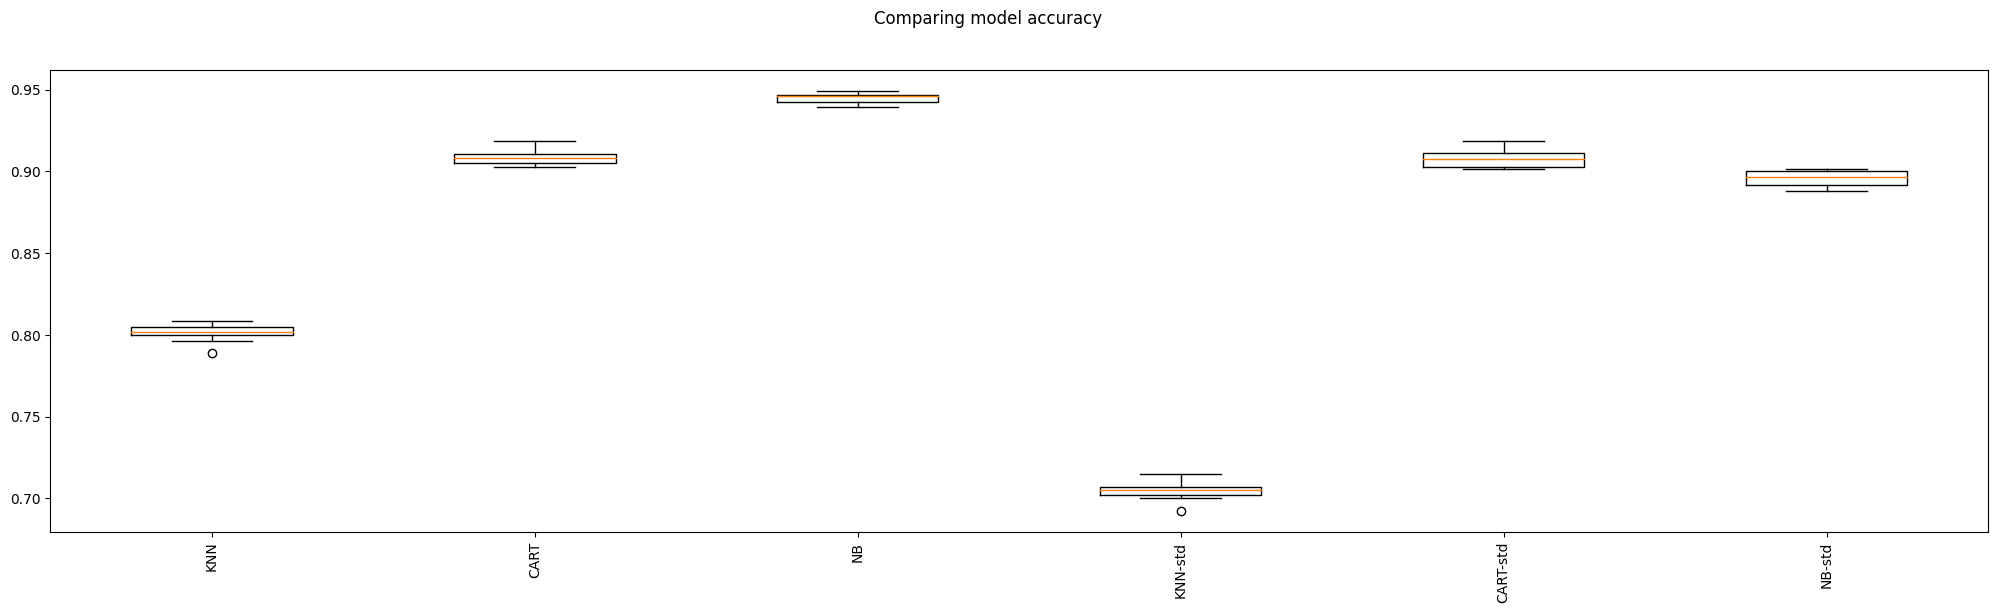

In [10]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparing model accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

# Final Evaluation against test dataset
After evaluating model performance usign kfold on training dataset we will test the models against an unbiased test dataset to have a final opinion if our model was capable of generalize well of it overfitted during training phase .

Output:
- Model name: KNN and Test Accuracy:0.80
- Model name: CART and Test Accuracy:0.91
- Model name: NB and Test Accuracy:0.95
- Model name: KNN-std and Test Accuracy:0.72
- Model name: CART-std and Test Accuracy:0.91
- Model name: NB-std and Test Accuracy:0.89

In [11]:
# Calculate Accuracy of test Dataset
# transform the test dataset
X_test_vec = vectorizer.transform(X_test.Description)

# Accuracy on test dataset
for name, model in pipelines:
  # make predictions on the test set
  yhat = best_models[name].predict(X_test_vec)

  # evaluate accuracy
  acc = accuracy_score(y_test, yhat)
  print(f'Model name: {name} and Test Accuracy:{acc:.2f}')

Model name: KNN and Test Accuracy:0.80
Model name: CART and Test Accuracy:0.91
Model name: NB and Test Accuracy:0.95
Model name: KNN-std and Test Accuracy:0.72
Model name: CART-std and Test Accuracy:0.91
Model name: NB-std and Test Accuracy:0.89


In [ ]:
# Classification report
for name, model in pipelines:
  # make predictions on the test set
  yhat = best_models[name].predict(X_test_vec)
  print(f"Classification Report for {name}:")
  print(classification_report(y_test, yhat))

# Select model and export model, label encoder and vectorizer

In [ ]:
from joblib import dump
from joblib import load

In [14]:
# Selected model
selected_model_name = 'NB'

# save the model
dump(best_models[name], open('model.joblib', 'wb'))
# save the vectorizer
dump(vectorizer, open('vectorizer.joblib', 'wb'))
# save the label encoder
dump(label_encoder, open('label_encoder.joblib', 'wb'))

# Simulate model usage on small sample

In [15]:
# load the model
model_joblib = load(open('model.joblib', 'rb'))
# load the vectorizer
vectorizer_joblib = load(open('vectorizer.joblib', 'rb'))
# load the label encoder
label_encoder_joblib = load(open('label_encoder.joblib', 'rb'))

In [17]:
# Testing model with ramdom descriptions
test_dict = {'Description':  ["Nike", "McDonalds", "Groceries", "Market", "Gas"]}
test_data = pd.DataFrame.from_dict(test_dict)
test_data_vec = vectorizer.transform(test_data.Description)

# Predição de classes dos dados de entrada
y_pred = model_joblib.predict(test_data_vec)
decoded_labels = label_encoder_joblib.inverse_transform(y_pred)
print(decoded_labels)

['Clothes' 'Food' 'Food' 'Home' 'Auto']


# Result Analysis

- the model selected was the Multinomial Naive Bayes since it reached the highest accuracy on cross validation and kept its performance on test dataset.
- an interesting point is that I observed that standartization worsened model performance in our case. I understood that the reason is that vectorizing the descriptions was already
- attention points:
  - I was not able to train SVM due to performance issues in Colab. It timed out twice and decided to exclude the SVM from the competing models
  - another thing is that we used only classical models but it would also be interesting to try LLMs and newer models to check how they perform in this classification problem